In [49]:
import matplotlib.pyplot as plt
import numpy as np
from utils import gen_example, get_laplacian_grid_1d
from scipy.sparse import identity, kron, diags_array
from qpsolvers import solve_qp
import clarabel

# FEM-H1

In this notebook, we will showcase the FEM-H1 method. Let us generate some noisy data to denoise

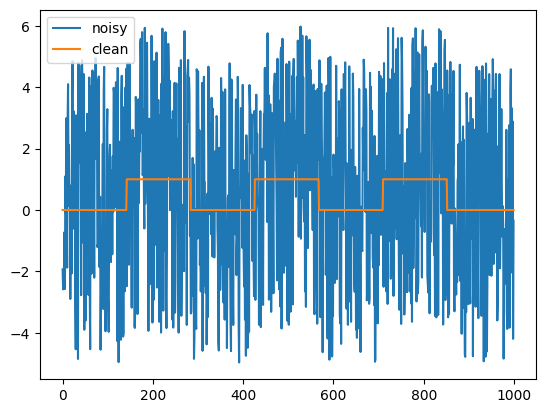

In [80]:
X, X_noisy = gen_example(noise=10.)
plt.plot(X_noisy)
plt.plot(X)
plt.legend(["noisy", "clean"])

Let us implement an object to perform FEMH1 denoising. Recall that the loss function for FEMH1 is
$$\mathcal{L}_\text{FEMH1} =\sum_{d,t,k=1}^{D,T,K}\Gamma_{k,t}(X_{d,t}-C_{d,k})^2+\varepsilon^2\sum_{k,t=1}^{K,T-1}(\Gamma_{k,t+1}-\Gamma_{k,t})^2$$
with the following constraints:
$$\forall~t,k:0\leq \Gamma_{k,t} \leq 1$$
and
$$\forall ~t: \sum_{k=1}^K \Gamma_{k,t}=1.$$

As such, we can extend our k-means code to include the modifications.
In particular, the additional term does not lead to change in the solution of the $C$ step, but only in the $\Gamma$ one. This problem is now a QP problem.

## $\varepsilon$ parameter
This parameter controls *how strongly* the smoothness should be enforced. We will later see the practical effects of choosing specific values.

In [81]:
class femh1_demo:
    def __init__(self,K,epsilon,max_iters=200,tol=1e-8):
        self.K = K
        self.epsilon=epsilon
        self.max_iters = max_iters
        self.tol = tol

    def __repr__(self):
        return "I am a FEMH1 model with K=%d and epsilon %.2e" % (self.K, self.epsilon)

    def fit(self,X):

        T = X.shape[0]

        # As with kmeans, we create centroids and affiliations
        self.S = X[np.random.randint(0,X.shape[0], self.K)] #centroid
        self.G = np.zeros((X.shape[0], self.K)) # affilitation vector with size Txk

        self.HG = (2*self.epsilon*kron(identity(self.K), get_laplacian_grid_1d(T))).tocsr() # Regurlaisierungsmatrix

        # Variables needed for QP problem
        self.A = kron(np.ones(self.K), identity(T)) # for every t the sum over all centroids in the affilitiantion is one
        self.b = np.ones(T)

        # Loop
        self.hist_C = []
        self.hist_G = []

        i = 0
        delta = np.inf
        prev_error = np.inf
        while i<self.max_iters and delta>self.tol:

            i+=1

            # Update affiliations
            self.errors = (np.kron(np.ones((self.K)), X) - np.kron(self.S, np.ones((T))))**2
            self.errors /= T

            self.gamma_vec = solve_qp(
                self.HG, self.errors,A=self.A,b=self.b,lb=np.zeros(T*self.K),
                solver="clarabel", initvals=self.G.T.flatten()
            )
            self.G = self.gamma_vec.reshape(self.K, T).T # new affilitiation matrix Txk Matrix
            

            # Update centroids by solving problem with fixed affiliations --> this problem is not quadratic anymore, second term in objective becomes constant
            # We can do the same as in k-means
            self.S = self.G.T @ X / np.sum(self.G.T, axis=1)
            
                      

        self.denoised = (self.S.reshape(1,-1) @ self.G.T).flatten()
        self.L_lin = np.dot(self.errors, self.gamma_vec)
        self.L_quad = np.dot((self.HG/(self.epsilon*2)) @ self.gamma_vec, self.gamma_vec)
        self.L = self.L_lin + self.epsilon*self.L_quad

In [82]:
m = femh1_demo(K=2, epsilon=1e-1)
m.fit(X_noisy)

The affiliations ($\Gamma$) are:

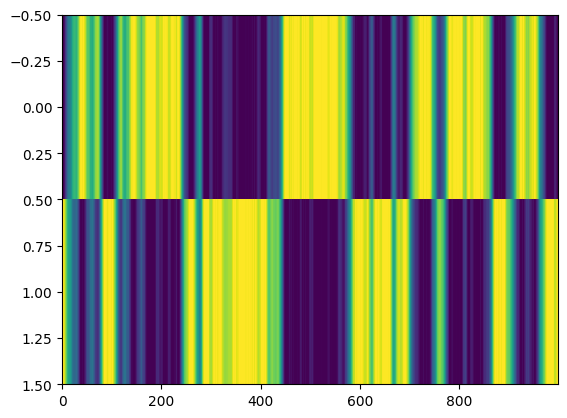

In [83]:
plt.imshow(m.G.T, aspect="auto", interpolation='none')

And the denoised trace is:

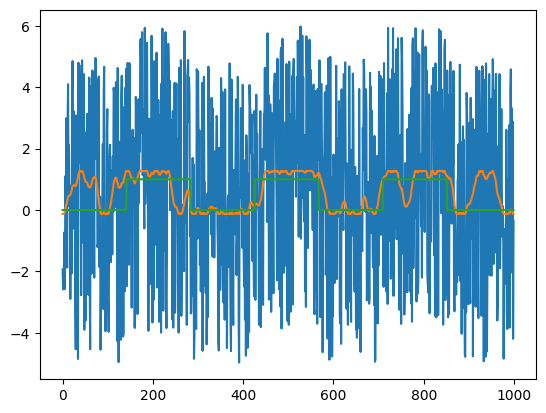

In [84]:
plt.plot(X_noisy)
plt.plot(m.denoised)
plt.plot(X)

## Selection of $\varepsilon$
In the following cell, you can interactively change epsilon and observe the effects on the denoising. Note how by increasing the regularization strength (i.e., with $\varepsilon \rightarrow \infty$), we obtain progressively smooth denoised traces, while for $\varepsilon \rightarrow 0$ we obtain the k-means solution.

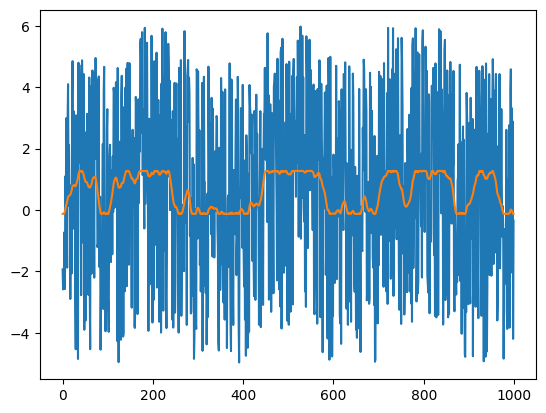

In [85]:
m_e = femh1_demo(K=2, epsilon=1e-1)
m_e.fit(X_noisy)
plt.plot(X_noisy)
plt.plot(m_e.denoised)

### Practical selection of $\varepsilon$
As for k-means, if we don't know which parameter to choose a-priori, we can explore different potential values

In [86]:
epsilons = np.logspace(-7,1,10)

errors = np.zeros(len(epsilons))
errors_l = np.zeros_like(errors)
errors_q = np.zeros_like(errors)

for index, epsilon in enumerate(epsilons):
    m_e = femh1_demo(K=2, epsilon=epsilon)
    m_e.fit(X_noisy)
    errors[index] = m_e.L
    errors_l[index] = m_e.L_lin
    errors_q[index] = m_e.L_quad

Text(0.5, 0, 'Smoothness error')

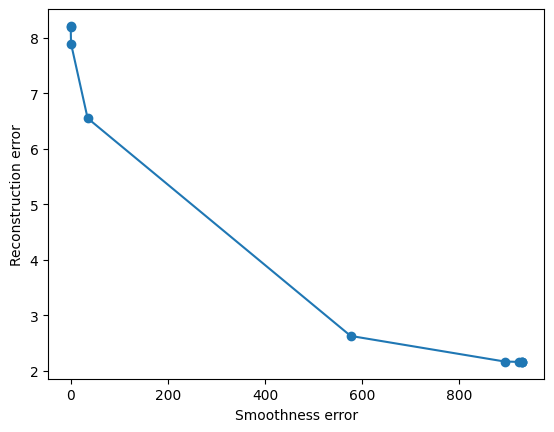

In [87]:
plt.plot(errors_q, errors_l)
plt.scatter(errors_q, errors_l)
plt.ylabel("Reconstruction error")
plt.xlabel("Smoothness error")

Text(0.5, 0, '$\\varepsilon$')

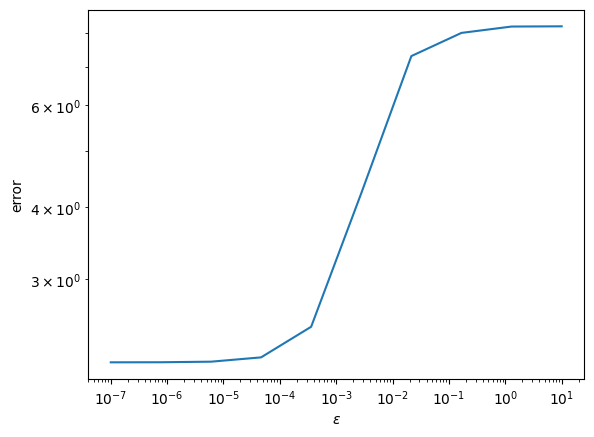

In [88]:
plt.plot(epsilons, errors)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('error')
plt.xlabel(r'$\varepsilon$')